In [50]:
# Imports
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import json



In [51]:
# Input Area
# The file name in merged_results
MERGED_RESULT_FILE_NAME = 'ricky1_20211018151416.csv'
MARGIN_LIMIT = 100000


In [52]:
# Read merged backtest results from csv
df_original = pd.read_csv('./merged_results/'+MERGED_RESULT_FILE_NAME)
df_original.head()
# Load extra info into dataframe as columes
dict_extra = df_original['extra'].to_dict()
for key in dict_extra.keys():
    extra_str = dict_extra[key].replace("False",'"False"')
    extra_str = extra_str.replace("True",'"True"')
    extra_str = extra_str.replace("'",'"')
    dict_extra[key] = json.loads(extra_str)
extra_df = pd.DataFrame.from_dict(dict_extra,orient='index')
df_original = pd.concat([df_original, extra_df], axis=1)

In [53]:
'''
Filters which is processed before analyse
'''
df = df_original.copy(deep = True)
# Price filter Template
#df = df[(df['open_price'] < 100) & (df['open_price'] >= 5)]
# Opendate filter Template
#df = df[df['open_date'] > '2019-06-01 00:00:00']

# Stocks name filter
#unwanted_list = ['AAPL_US']
# df = df[~df['symbol'].isin(unwanted_list)]
df

,Unnamed: 0,order_ref,volume,filled,symbol,open_price,open_filled_price,close_price,close_filled_price,direction,...,true_profit,pnl_cum,pnl_cum_true,order_type,month_1_rank,month_3_rank,month_6_rank,calm_after_storm_condition_b_1,calm_after_storm_condition_b_2,calm_after_storm_condition_b_3
0,5413,RI1:73524ee2-a5e7-41dc-b1cd-cb9600285840,54,54,NKE_US,91.94,91.94,81.890000,81.890000,long,...,-544.700000,-542.700000,-544.700000,trail,0.121912,0.147512,0.236842,False,False,True
1,14258,RI1:7000ecb7-f235-469b-8bf4-a67fd65c8372,58,58,SGEN_US,85.84,85.84,99.574400,99.574400,long,...,794.595200,253.895200,249.895200,fixed,0.051020,0.057107,0.200501,False,False,True
2,14260,RI1:87a36185-5130-496c-8630-009825407a8a,58,58,SGEN_US,85.84,85.84,115.637451,115.637451,long,...,1726.252157,1982.147357,1976.147357,trail,0.051020,0.057107,0.200501,False,False,True
3,5412,RI1:13c83831-4874-4302-829e-c2586d7ebbd5,54,54,NKE_US,91.94,91.94,81.890000,81.890000,long,...,-544.700000,1439.447357,1431.447357,fixed,0.121912,0.147512,0.236842,False,False,True
4,12727,RI1:f81b0eef-3a36-4c34-9fcf-e963bef84af1,3,3,WFC.L_US,1508.47,1508.47,1386.228400,1386.228400,long,...,-368.724800,1072.722557,1062.722557,trail,0.258861,0.121375,0.158790,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18091,16628,RI1:1456b41b-b352-463f-8fd4-5127eb26e30c,508,508,SGMA_US,9.83,9.83,10.149700,10.149700,long,...,155.295600,313057.124952,173450.302952,trail,0.009505,0.009198,0.042312,True,True,True
18092,10234,RI1:8906dc88-26d8-465d-8ed7-ba1b0df56c5e,62,62,GPOR_US,79.94,79.94,81.000000,81.000000,long,...,63.720000,313122.844952,173514.022952,trail,0.072973,0.066994,0.000460,False,False,True
18093,10233,RI1:7b7ce4ec-9d09-42b0-aecc-5f1819e32b06,62,62,GPOR_US,79.94,79.94,81.000000,81.000000,long,...,63.720000,313188.564952,173577.742952,fixed,0.072973,0.066994,0.000460,False,False,True
18094,12405,RI1:d7fb516e-1cb4-4761-8cfb-26a3a6903cc1,285,285,CHRS_US,17.54,17.54,17.750000,17.750000,long,...,55.860000,313248.414952,173633.602952,fixed,0.129082,0.079411,0.275640,True,False,True


In [54]:
'''
Basic Analyse
'''
GRAINESS = 5
df['entry_price_in_grainess'] =(df['open_price']/GRAINESS).astype(int) * GRAINESS
grouped = df.groupby('entry_price_in_grainess')
profit_distribute = grouped[['profit']].sum()
true_profit_distribute = grouped[['true_profit']].sum()
# Profit cumsum
df['pnl_cum_true'] = df['true_profit'].cumsum()
df['pnl_cum'] = df['profit'].cumsum()

# Margin cumsum
margin_event = []
for index, row in df.iterrows():
    event_temp = {
        "date":row['open_date'],
        "amount":abs(row["margin"])
    }
    margin_event.append(event_temp)
    event_temp = {
        "date":row['close_date'],
        "amount":0-abs(row["margin"])
    }
    margin_event.append(event_temp)
margin_event = sorted(margin_event, key=lambda k: k['date']) 
margin_df = pd.DataFrame(margin_event)
margin_df['margin_total'] = margin_df['amount'].cumsum()
margin_df = margin_df.set_index('date')
dict_margin_df = margin_df['margin_total'].to_dict()
df['margin_total'] = df['open_date'].map(dict_margin_df).fillna(method='ffill')
# Orders distribution in month-year category
df['open_date_month_and_year'] = df['open_date'].apply(lambda x:x[0:7])
df['open_date_month_and_year_count'] = 1
month_and_year_distribute = df.groupby('open_date_month_and_year')[['profit','open_date_month_and_year_count']].sum()

# Profit by limited margin
margin_event = []
for index, row in df.iterrows():
    event_temp = {
        "date":row['open_date'],
        "margin":abs(row["margin"]),
        "profit":0,
        "true_profit":0,
        "order_ref":row["order_ref"]
    }
    margin_event.append(event_temp)
    event_temp = {
        "date":row['close_date'],
        "margin":0-abs(row["margin"]),
        "profit":row['profit'],
        "true_profit":row['true_profit'],
        "order_ref":row["order_ref"]
    }
    margin_event.append(event_temp)
margin_event = sorted(margin_event, key=lambda k: k['date']) 
print("Before Limit Margin Length",len(margin_event))
current_margin = 0
skip_list = []
for event in margin_event:
    if event["margin"] < 0:
        if event["order_ref"] not in skip_list:
            current_margin = current_margin + event["margin"]
    else:
        if current_margin < MARGIN_LIMIT:
            current_margin = current_margin + event["margin"]
            pass
        else:
            skip_list.append(event["order_ref"])
remove_list = []
for event in margin_event:
    if event["order_ref"] in skip_list:
         remove_list.append(event)
for event in remove_list:
    margin_event.remove(event)
print("After Limit Margin Length",len(margin_event))
margin_limit_df = pd.DataFrame(margin_event)
margin_limit_df["limited_margin_total"] = margin_limit_df["margin"].cumsum()
margin_limit_df["profit_total"] = margin_limit_df["profit"].cumsum()
margin_limit_df["true_profit_total"] = margin_limit_df["true_profit"].cumsum()

Before Limit Margin Length 36192
After Limit Margin Length 5694


<AxesSubplot:xlabel='date'>

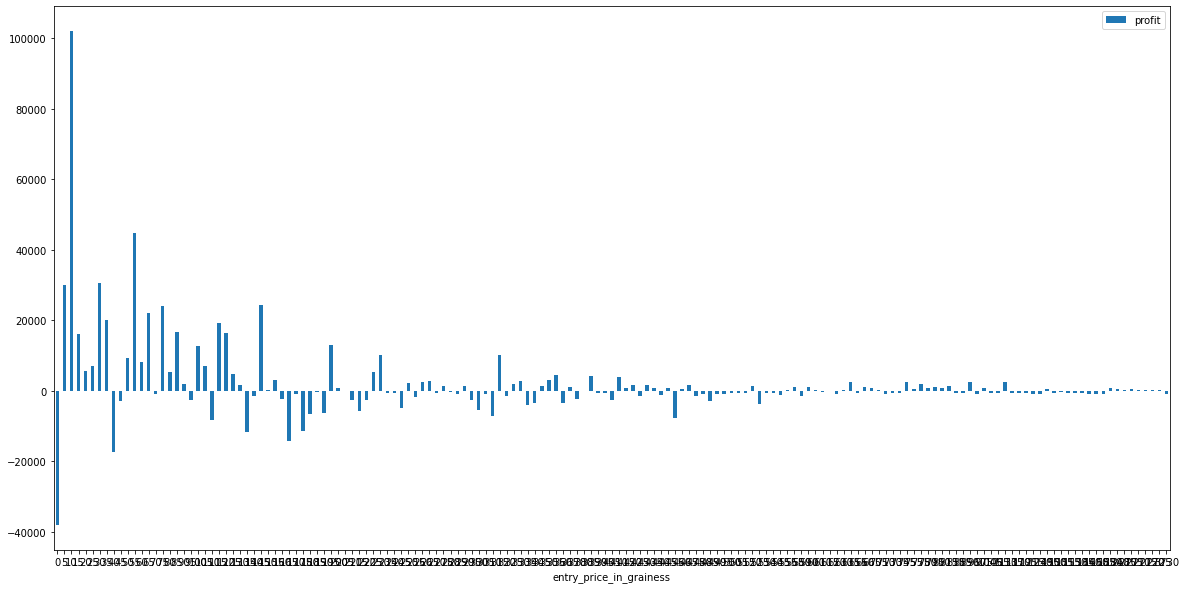

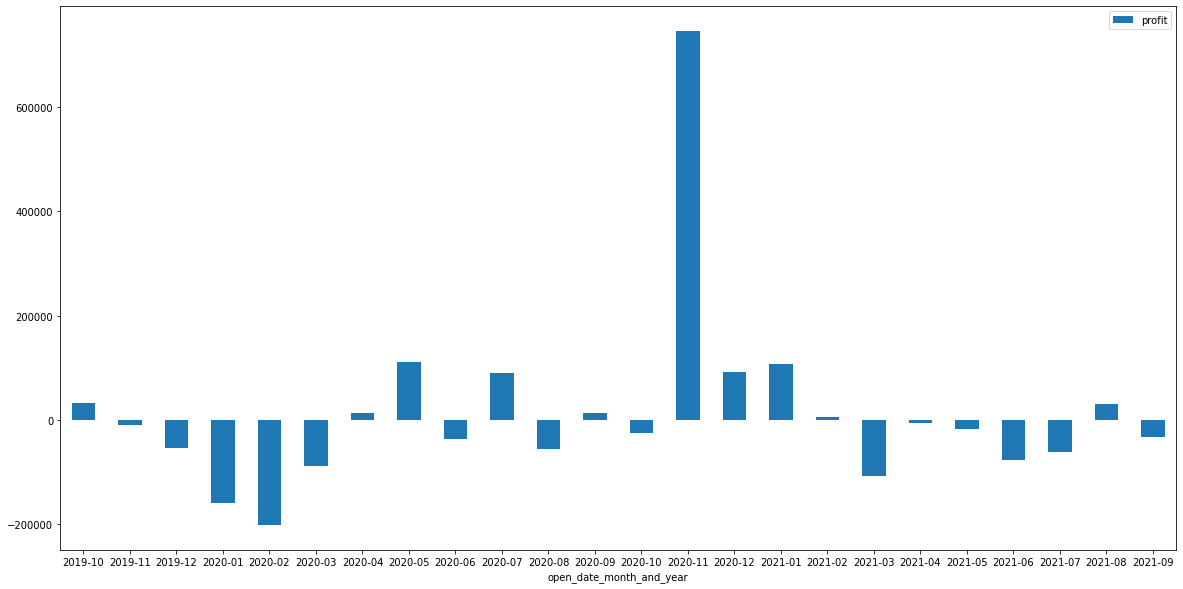

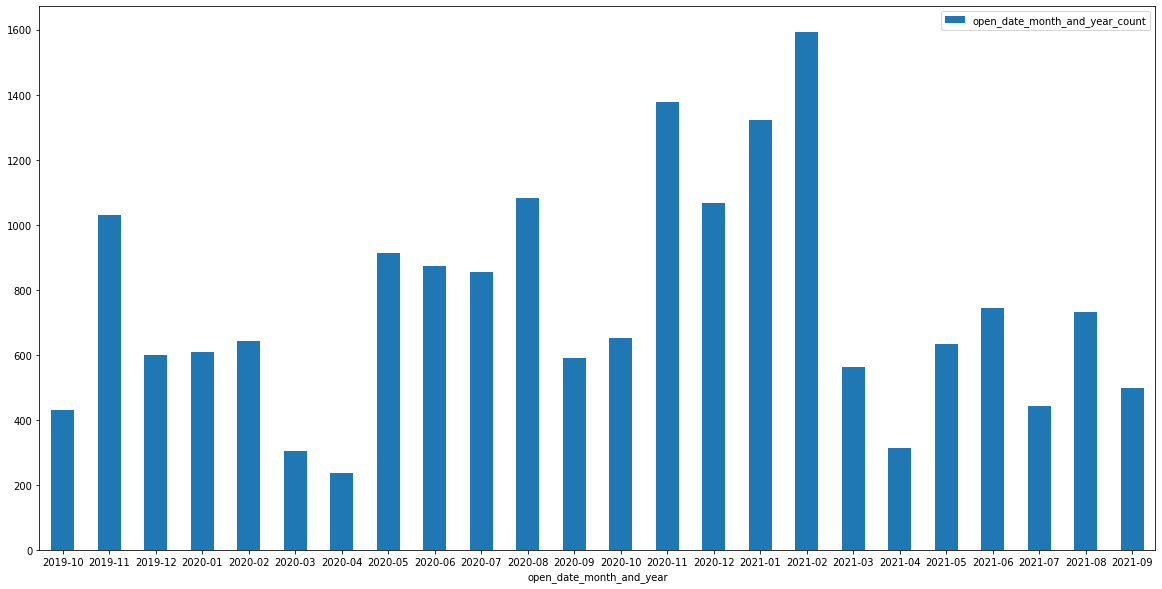

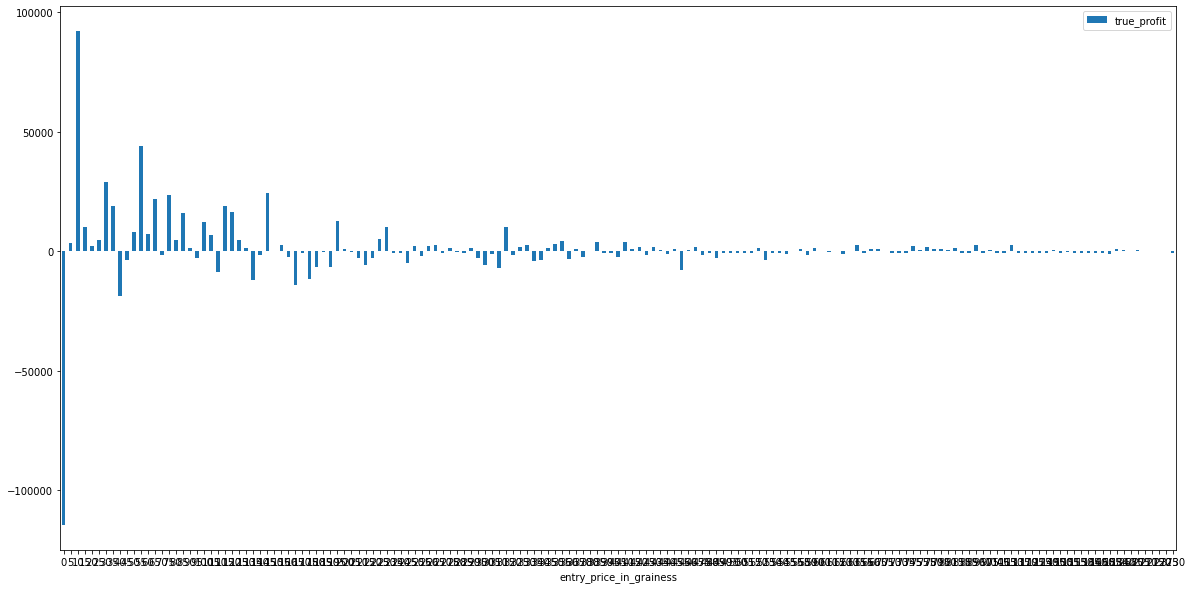

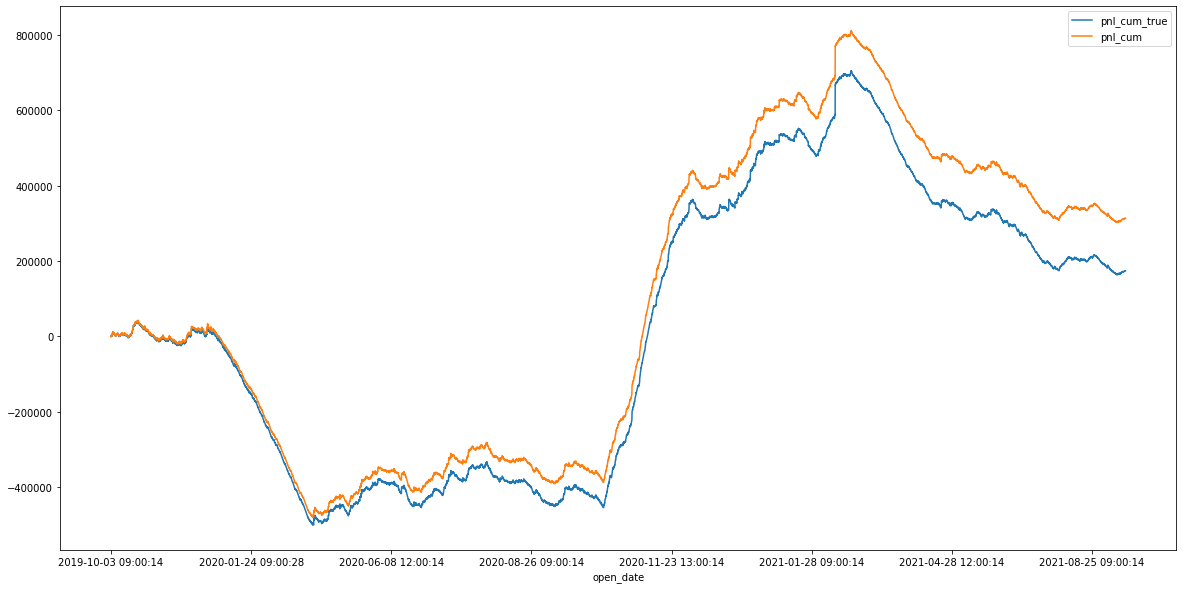

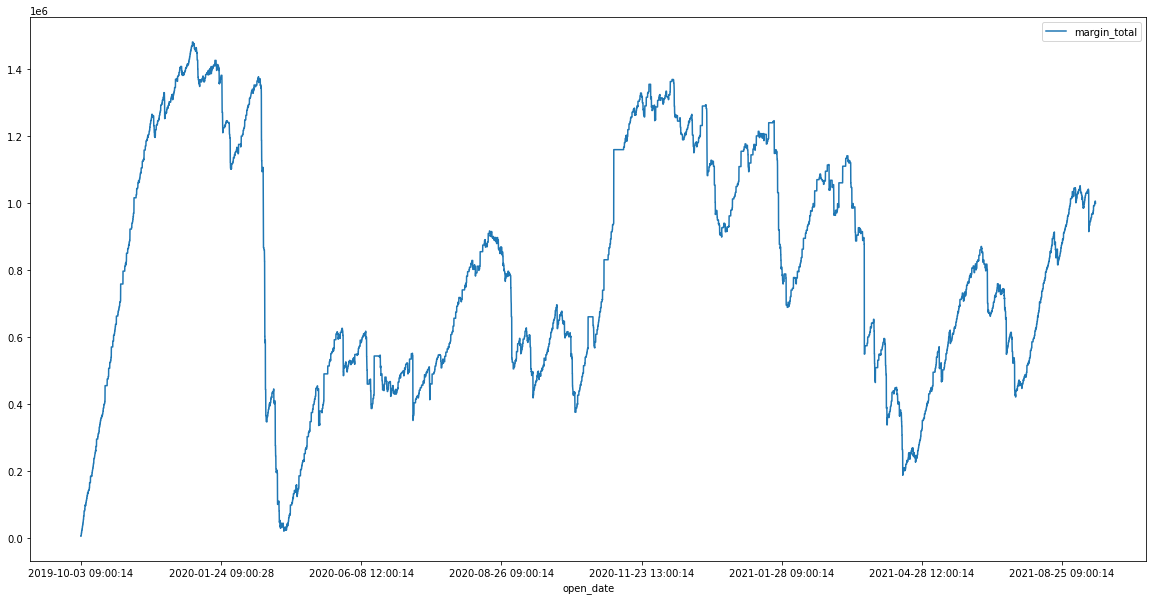

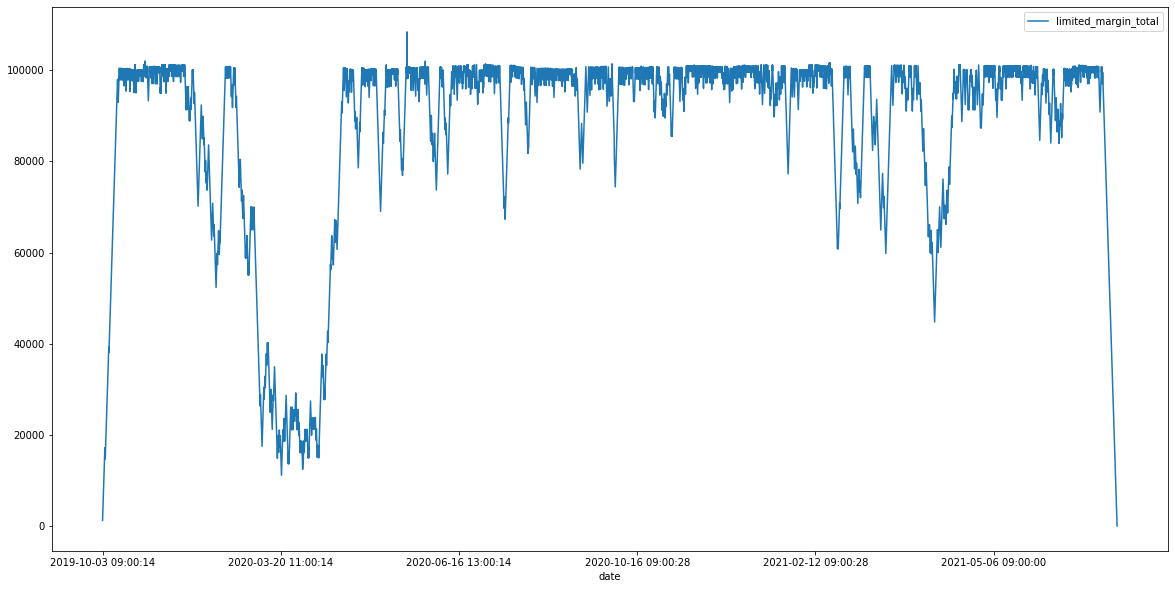

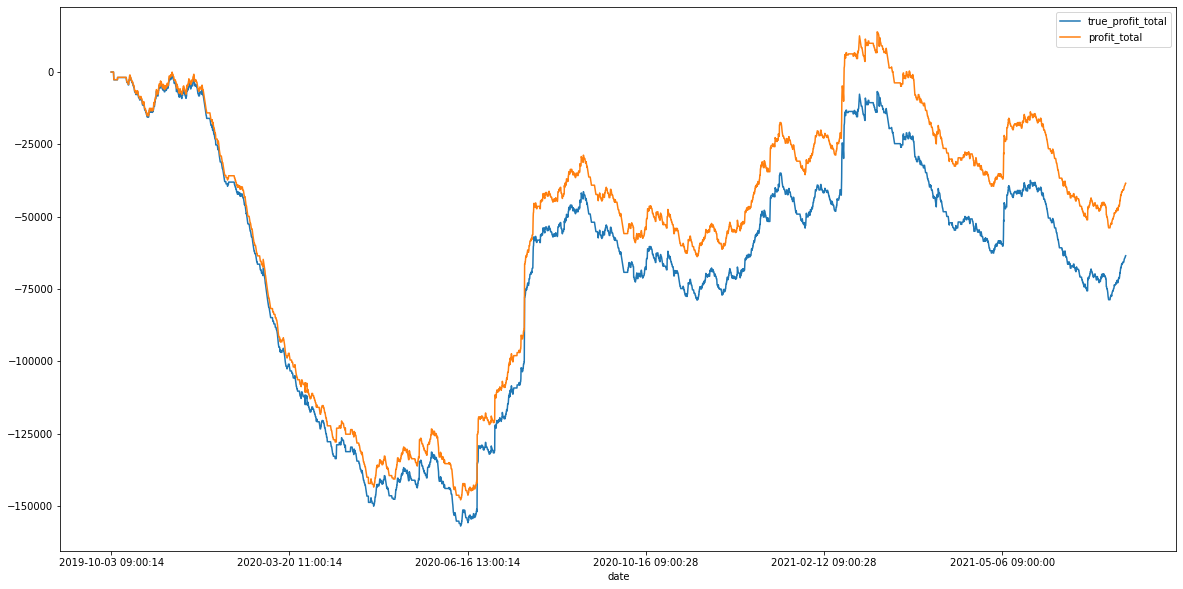

In [55]:
# Draw
profit_distribute.plot.bar( y='profit', rot=0,figsize=(20,10))
month_and_year_distribute.plot.bar( y='profit', rot=0,figsize=(20,10))
month_and_year_distribute.plot.bar( y='open_date_month_and_year_count', rot=0,figsize=(20,10))
true_profit_distribute.plot.bar( y='true_profit', rot=0,figsize=(20,10))
df.plot.line(x='open_date', y=['pnl_cum_true','pnl_cum'],figsize=(20,10))
df.plot.line(x='open_date', y=['margin_total'],figsize=(20,10))

margin_limit_df.plot.line(x='date', y=['limited_margin_total'],figsize=(20,10))
margin_limit_df.plot.line(x='date', y=['true_profit_total',"profit_total"],figsize=(20,10))

In [56]:
# Print
print("====================Basic Info===================")
print("Total true profit",df['true_profit'].sum())
print("Avg win in perc",str(((df['close_price']-df['open_price'])/df['open_price']).mean() * 100) + '%')
print("Win rate",str(df[df['profit'] > 0].shape[0] / df.shape[0] * 100)+ '%' )
print("Total orders",df.shape[0])
print("Total commissions",df['commission'].sum())
print("Total profit",df['profit'].sum())
print("=========Order Distribution In Year-Month=========")
print(month_and_year_distribute.describe())

====================Basic Info===================
Total true profit 173689.46295194063
Avg win in perc 0.37921116484051154%
Win rate 32.69230769230769%
Total orders 18096
Total commissions -139618.802
Total profit 313308.2649519405
=========Order Distribution In Year-Month=========
              profit  open_date_month_and_year_count
count      24.000000                        24.00000
mean    13054.511040                       754.00000
std    174267.025282                       350.26971
min   -201318.935888                       235.00000
25%    -56527.239679                       545.50000
50%    -13166.145772                       647.00000
75%     31725.065442                       942.75000
max    745492.253572                      1592.00000


In [57]:
'''
Custom Analyse
'''


'\nCustom Analyse\n'